In [3]:
# !pip install -qr "../requirements.txt"
# !pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 MB 6.0 MB/s eta 0:00:0000:0100:01


In [1]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../')

# Load data

## Load data - Demonstration

In [11]:
df = pd.read_csv('../data/drive-me-not/trace1.csv')
# benign_flight.info()

#filter out the anchor points
df = df[df['Anchor_Number'] == 0]
df

,GPS_lat,GPS_long,Network_lat,Network_long,Time,Anchor_Number,Type,Registered,CID,LAC,MCC,MNC,dBm,level
0,25.328347,51.425060,0.0,0.0,1561278474631,0,GSM,True,23733,9301,427,1,-45,4
14,25.328347,51.425060,0.0,0.0,1561278474768,0,GSM,True,23733,9301,427,1,-45,4
28,25.328347,51.425060,0.0,0.0,1561278474932,0,GSM,True,23733,9301,427,1,-45,4
42,25.328347,51.425060,0.0,0.0,1561278475082,0,GSM,True,23733,9301,427,1,-45,4
56,25.328347,51.425060,0.0,0.0,1561278475263,0,GSM,True,23733,9301,427,1,-45,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34038,25.331563,51.421738,0.0,0.0,1561280145472,0,GSM,True,24882,9301,427,1,-57,4
34050,25.331563,51.421738,0.0,0.0,1561280155660,0,GSM,True,14792,150,427,2,-37,4
34057,25.331563,51.421738,0.0,0.0,1561280155829,0,GSM,True,24882,9301,427,1,-53,4
34070,25.331563,51.421738,0.0,0.0,1561280156156,0,GSM,True,24882,9301,427,1,-53,4


In [12]:
import pandasql as ps

# Filter out the rows whose change of position is not reflected in the coordinates
stmt = """SELECT * 
FROM df
WHERE Time in (
    SELECT min(Time) 
    FROM df
    GROUP BY GPS_lat, GPS_long 
    )
"""

df = ps.sqldf(stmt, locals())

In [13]:
from utils.haversine import haversine_component_distance

haversine_dist_lat, haversine_dist_lon = [], []

for rows in range(1, len(df)):
    dist =  haversine_component_distance(
        (df.loc[rows-1, 'GPS_lat'], df.loc[rows-1, 'GPS_long']), 
        (df.loc[rows, 'GPS_lat'], df.loc[rows, 'GPS_long'])
        )
    haversine_dist_lat.append(dist[0])
    haversine_dist_lon.append(dist[1])
    
pd.Series(haversine_dist_lat) / df.Time.diff().dropna().reset_index(drop=True)
pd.Series(haversine_dist_lon) / df.Time.diff().dropna().reset_index(drop=True)

0      0.000072
1      0.000057
2      0.000052
3      0.000081
4      0.000084
         ...   
527    0.000358
528    0.000111
529    0.001318
530    0.000291
531    0.000167
Length: 532, dtype: float64

In [14]:
df['vx'] = pd.Series(haversine_dist_lat) / df.Time.diff().dropna().reset_index(drop=True)
df['vy'] = pd.Series(haversine_dist_lon) / df.Time.diff().dropna().reset_index(drop=True)
df.dropna(inplace=True)

# compute acceleration
df['ax'] = df.vx.diff() / df.Time.diff()
df['ay'] = df.vy.diff() / df.Time.diff()
df.dropna(inplace=True)

In [15]:
from utils.preprocessing import zero_one_normalization

# compute velocity
df['vx'] = df.GPS_long.diff() / df.Time.diff()
df['vy'] = df.GPS_lat.diff() / df.Time.diff()
df.dropna(inplace=True)

# compute acceleration
df['ax'] = df.vx.diff() / df.Time.diff()
df['ay'] = df.vy.diff() / df.Time.diff()
df.dropna(inplace=True)

# 0-1 normalization

for col in ['vx', 'vy', 'ax', 'ay']:
    df[col] = zero_one_normalization(df[col])

selected_attributes = ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'dBm']
df = df[selected_attributes]
df

,GPS_lat,GPS_long,Time,vx,vy,ax,ay,dBm
3,25.328287,51.425072,1561278478996,0.587604,0.699785,0.602825,0.809960,-45
4,25.328255,51.425058,1561278480021,0.586167,0.698232,0.602545,0.810076,-45
5,25.328198,51.425045,1561278481009,0.586019,0.688861,0.602755,0.808792,-47
6,25.328133,51.425027,1561278481964,0.584285,0.685068,0.602475,0.809680,-47
7,25.328065,51.425008,1561278483007,0.584777,0.685970,0.602859,0.810459,-47
...,...,...,...,...,...,...,...,...
527,25.330870,51.420990,1561280127048,0.611872,0.751969,0.602842,0.810413,-53
528,25.331425,51.421340,1561280133158,0.607548,0.741344,0.602661,0.810040,-59
529,25.331608,51.421440,1561280138810,0.595506,0.720661,0.602422,0.809730,-59
530,25.331632,51.421472,1561280138960,0.654338,0.764265,0.668577,0.857162,-59


In [16]:
from utils.visualization import plot_trace

plot_trace(df, mode="velocity")

## Pipelining the dataloader

In [2]:
from utils.preprocessing import data_preprocessing

traces = ['../data/drive-me-not/trace'+ str(i) + '.csv' for i in range(1, 9)]

traces_df = [data_preprocessing(trace, trace_num=i+1, method="haversine") for i, trace in enumerate(traces)]

for df in traces_df:
    print(df.shape)

(531, 7)
(564, 7)
(316, 7)
(463, 7)
(297, 7)
(393, 7)
(396, 7)
(318, 7)


## Malicious Data

In [6]:
# trace 4 spoofed
from utils.preprocessing import data_preprocessing

# spoofed = pd.read_csv('../data/drive-me-not/trace4_spoofed.csv').drop(columns=['Unnamed: 0']).head()  


# estimated_trace4, trace4_spoofed 
# spoofed_4 = data_preprocessing('../data/drive-me-not/processed/trace4_spoofed.csv', 
#                              selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
#                              trace_num=4)

TRACE = 1

spoofed_data = data_preprocessing('../data/drive-me-not/spoofed/spoofed_trace'+str(TRACE)+'.csv', 
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                             trace_num=TRACE)
benign_data = data_preprocessing('../data/drive-me-not/trace'+str(TRACE)+'.csv',
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay'], 
                             trace_num=TRACE)
benign_data['spoofed'] = 0


from utils.visualization import plot_trace

x_range_s, y_range_s = (spoofed_data.GPS_lat.min(), 
         spoofed_data.GPS_lat.max()), \
        (spoofed_data.GPS_long.min(), 
         spoofed_data.GPS_long.max())
        
x_range_b, y_range_b = (benign_data.GPS_lat.min(), 
         benign_data.GPS_lat.max()), \
        (benign_data.GPS_long.min(), 
         benign_data.GPS_long.max())
        
x_range, y_range = (min(x_range_s[0], x_range_b[0]), 
                   max(x_range_s[1], x_range_b[1])), \
                  (min(y_range_s[0], y_range_b[0]), 
                   max(y_range_s[1], y_range_b[1]))

plot_trace(spoofed_data.iloc[:, :], 
           mode="velocity", 
           colored=True, marker_size=2,
           x_range=y_range, 
           y_range=x_range,
           )

# plot_trace(benign_data.iloc[:, :], 
#            mode="velocity", 
#            colored=True, marker_size=2,
#            x_range=y_range, 
#            y_range=x_range,
#            )

In [8]:
benign_4 = data_preprocessing('../data/drive-me-not/trace4.csv',
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay'], 
                             trace_num=4)
benign_4['spoofed'] = 0
plot_trace(benign_4.iloc[:, :], 
        #    mode="velocity", 
           colored=True, marker_size=2)

# plot trace

In [11]:
from utils.preprocessing import data_preprocessing

spoofed_list = [data_preprocessing('../data/drive-me-not/spoofed/spoofed_trace'+str(trace)+'.csv', 
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                             trace_num=trace) for trace in range(1, 9)]
benign_list = [data_preprocessing('../data/drive-me-not/trace'+str(trace)+'.csv',
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay'], 
                             trace_num=trace) for trace in range(1, 9)]
for benign in benign_list:  
    benign['spoofed'] = 0
    
from utils.visualization import plot_spoofed_and_benign

plot_spoofed_and_benign(spoofed_list, benign_list, marker_size=2)

benign_list[0]

,GPS_lat,GPS_long,Time,vx,vy,ax,ay,trace,spoofed
1,25.328332,51.425088,1561278477081,0.010072,0.004713,0.976035,0.959217,1,0
2,25.328313,51.425080,1561278477990,0.013238,0.004259,0.976119,0.959217,1,0
3,25.328287,51.425072,1561278478996,0.015429,0.006688,0.975942,0.959629,1,0
4,25.328255,51.425058,1561278480021,0.028643,0.006939,0.977400,0.959323,1,0
5,25.328198,51.425045,1561278481009,0.033991,0.009870,0.976382,0.959707,1,0
...,...,...,...,...,...,...,...,...,...
527,25.330870,51.420990,1561280127048,0.045363,0.029437,0.975410,0.959168,1,0
528,25.331425,51.421340,1561280133158,0.016199,0.009091,0.974996,0.958817,1,0
529,25.331608,51.421440,1561280138810,0.077685,0.108470,0.977126,0.961773,1,0
530,25.331632,51.421472,1561280138960,0.005971,0.023974,0.910602,0.879686,1,0


[1, 2, 3, 4]

# PCA preprocessing

In [3]:
# union all the traces
df_processed_with_trace = pd.concat(traces_df)


trace_num = df_processed_with_trace['trace'].astype("int")

# # exclude trace 4 for testing
# df_processed_without_4 = df_processed_with_trace[df_processed_with_trace['trace'] != 4]
# df_processed = df_processed_without_4.drop(columns=['trace'])

# # Donot exclude trace 4 for testing
df_processed = df_processed_with_trace.drop(columns=['trace'])


# standard scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_processed)
df_processed = pd.DataFrame(scaler.transform(df_processed), columns=df_processed.columns)

trace_num.reset_index(drop=True, inplace=True)

# pca transformation
from utils.preprocessing import pca_transform

N_COMPONENTS = 3

df_train, pca_train = pca_transform(df_processed, n_components=N_COMPONENTS)
df_train['trace'] = trace_num
df_train

,pca-one,pca-two,pca-three,trace
0,0.960071,0.443752,0.732593,1
1,0.959436,0.444372,0.732361,1
2,0.958636,0.445725,0.731010,1
3,0.955913,0.449111,0.729489,1
4,0.953925,0.451199,0.727151,1
...,...,...,...,...
3273,0.773919,0.752050,0.265273,8
3274,0.466864,0.182363,0.368353,8
3275,0.927748,0.461647,0.669547,8
3276,0.916483,0.470821,0.666389,8


## process the spoofed data

In [4]:
# fields_for_pca = ['GPS_lat', 'GPS_long', 'vx', 'vy', 'ax', 'ay']

# # standard scaling
# spoofed_4_scaled = pd.DataFrame(scaler.transform(spoofed_4[fields_for_pca]), columns=spoofed_4[fields_for_pca].columns)

# spoofed_pca = pca_train.transform(spoofed_4_scaled)

# spoofed_for_test = pd.DataFrame(spoofed_pca, columns=['pca-one', 'pca-two', 'pca-three'])
# spoofed_for_test['label'] = spoofed_4.spoofed.reset_index()['spoofed']
# spoofed_for_test.label[1]

In [5]:
def process_spoofed_data(spoofed, scaler, pca_train):
    fields_for_pca = ['GPS_lat', 'GPS_long', 'vx', 'vy', 'ax', 'ay']

    # standard scaling
    spoofed_scaled = pd.DataFrame(scaler.transform(spoofed[fields_for_pca]), columns=spoofed[fields_for_pca].columns)

    spoofed_pca = pca_train.transform(spoofed_scaled)

    spoofed_for_test = pd.DataFrame(spoofed_pca, columns=['pca-one', 'pca-two', 'pca-three'])
    spoofed_for_test['label'] = spoofed.spoofed.reset_index()['spoofed']
    
    return spoofed_for_test

## legacy code

In [6]:
# # pca
# from utils.preprocessing import pca_transform, add_traces

# N_COMPONENTS = 3

# pca_dfs = [add_traces(df=pca_transform(df, n_components=N_COMPONENTS), num=i+1) for i, df in enumerate(traces_df)]

# pca_dfs = pd.concat(pca_dfs)
# pca_dfs['trace'] = pca_dfs['trace'].astype(int).astype(str)
# pca_dfs.reset_index(drop=True, inplace=True)
# pca_dfs

## visualize pca results

In [7]:
from utils.visualization import plot_pca

plot_pca(df_train, n_components=N_COMPONENTS)

# One-class Classification

## OCSVM

One-class SVM

In [8]:
df_train_svm = df_train[['pca-one', 'pca-two', 'pca-three']]

In [69]:
from models.ocsvm import optimize_OneClassSVM

nu_opt, gamma_opt = optimize_OneClassSVM(df_train_svm, 20)

nu_opt, gamma_opt

Searching for optimal hyperparameters...
Found: nu = 0.5421052631578948, gamma = 0.0036848421052631582


(0.5421052631578948, 0.0036848421052631582)

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

          -1    0.49784   1.00000   0.66474       230
           1    0.00000   0.00000   0.00000       232

    accuracy                        0.49784       462
   macro avg    0.24892   0.50000   0.33237       462
weighted avg    0.24784   0.49784   0.33093       462



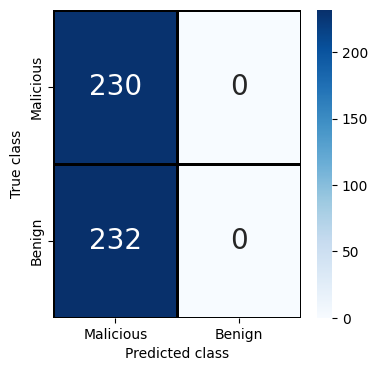

In [22]:
import pickle
from sklearn.svm import OneClassSVM
from sklearn import metrics
from utils.visualization import plot_cf_matrix

nu = 0.5421052631578948
gamma = 0.0036848421052631582

model = OneClassSVM(nu=nu, kernel="rbf", gamma = gamma)
model.fit(df_train_svm.values)

with open(f'../saved_models/pca_ocsvm/ocsvm_nu_{nu}_gamma_{gamma}.pkl', 'wb') as file:
    pickle.dump(model, file)

# change label to match oc svm
label_ocsvm = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
spoofed_for_test['label_ocsvm'] = label_ocsvm
 
y_pred = model.predict(spoofed_for_test[['pca-one', 'pca-two', 'pca-three']].values)
y_true = spoofed_for_test.label_ocsvm

print(metrics.classification_report(y_true, y_pred, digits=5))
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
plot_cf_matrix(conf_matrix)

### Train on all traces - OCSVM


In [12]:
import pickle
from sklearn.svm import OneClassSVM
from sklearn import metrics
from utils.visualization import plot_cf_matrix

from models.ocsvm import optimize_OneClassSVM



nu_opt, gamma_opt = optimize_OneClassSVM(df_train_svm, 20)

# round to 5 decimal places

nu = round(nu_opt, 5)
gamma = round(gamma_opt, 5)

model = OneClassSVM(nu=nu, kernel="rbf", gamma = gamma)
model.fit(df_train_svm.values)

with open(f'../saved_models/pca_ocsvm/ocsvm_nu_{nu}_gamma_{gamma}.pkl', 'wb') as file:
    pickle.dump(model, file)

Searching for optimal hyperparameters...
Found: nu = 0.5421052631578948, gamma = 0.026323157894736843


In [ ]:
import pickle
from sklearn.svm import OneClassSVM
from sklearn import metrics

# Load the pickled model
with open(f'../saved_models/pca_ocsvm/ocsvm_nu_{nu}_gamma_{gamma}.pkl', 'rb') as file:
    model = pickle.load(file)

from utils.visualization import plot_cf_matrix

conf_matrix_list = []

for trace in range(1, 9):

    spoofed_data = data_preprocessing('../data/drive-me-not/spoofed/spoofed_trace'+str(trace)+'.csv',
                                    selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                                    trace_num=trace)

    spoofed_for_test = process_spoofed_data(spoofed_data, scaler, pca_train)

    # change label to match oc svm
    label_ocsvm = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
    spoofed_for_test['label_ocsvm'] = label_ocsvm
    
    y_pred = model.predict(spoofed_for_test[['pca-one', 'pca-two', 'pca-three']].values)
    y_true = spoofed_for_test.label_ocsvm

    print(metrics.classification_report(y_true, y_pred, digits=5))
    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    conf_matrix_list.append(conf_matrix)
    
    plot_cf_matrix(conf_matrix, 
                title=f'Trace {trace} - Confusion Matrix\nnu={nu}, gamma={gamma}',
                path=f'../outputs/img/ocsvm/trace{trace}_cf_matrix_nu_{nu_opt}_gamma_{gamma_opt}.png')

## Local Outlier Factor (LOF)

### lof data preparation

In [17]:
df_train_lof = df_train[['pca-one', 'pca-two', 'pca-three']]
df_train_lof

,pca-one,pca-two,pca-three
0,0.960071,0.443752,0.732593
1,0.959436,0.444372,0.732361
2,0.958636,0.445725,0.731010
3,0.955913,0.449111,0.729489
4,0.953925,0.451199,0.727151
...,...,...,...
3273,0.773919,0.752050,0.265273
3274,0.466864,0.182363,0.368353
3275,0.927748,0.461647,0.669547
3276,0.916483,0.470821,0.666389


In [10]:
label_lof = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
spoofed_for_test['label_lof'] = label_lof
spoofed_for_test

,pca-one,pca-two,pca-three,label,label_lof
0,-1.439346,4.153807,-0.866847,0,1
1,-1.395856,4.423392,-1.049596,0,1
2,-1.970696,3.556558,-0.702043,0,1
3,-1.907315,3.772671,-0.837110,0,1
4,-1.791436,3.978190,-0.942015,0,1
...,...,...,...,...,...
457,-1.314267,3.212300,-2.362250,1,-1
458,-1.335627,3.184107,-2.359143,1,-1
459,-1.456717,3.033321,-2.332215,1,-1
460,-1.327511,3.180854,-2.377327,1,-1


### train lof

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_recall_fscore_support as score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns

from utils.visualization import plot_cf_matrix
from models.lof import optimize_LocalOutlierFactor

neighbor_opt, fscore = optimize_LocalOutlierFactor(
    df_train_lof, 
    spoofed_for_test, 
    neighbors_arange=(10,3000,100)
    )
    
print("Highest acheived macro average F1 was %f using %f neighbours" % (fscore, neighbor_opt))
print(metrics.classification_report(y_true, y_pred, digits=5))
print(conf_matrix)

### Train on each trace

Trace {trace}: Highest acheived macro average F1 was 0.332075 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49686   1.00000   0.66387       158
           1    0.00000   0.00000   0.00000       160

    accuracy                        0.49686       318
   macro avg    0.24843   0.50000   0.33193       318
weighted avg    0.24687   0.49686   0.32985       318



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



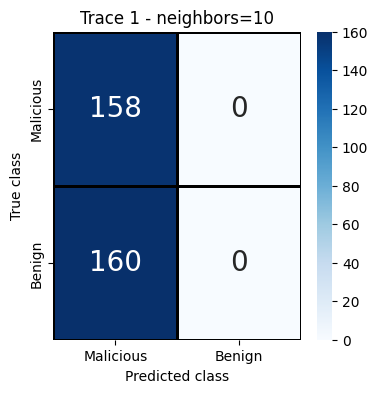

Trace {trace}: Highest acheived macro average F1 was 0.331354 using 110.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49686   1.00000   0.66387       158
           1    0.00000   0.00000   0.00000       160

    accuracy                        0.49686       318
   macro avg    0.24843   0.50000   0.33193       318
weighted avg    0.24687   0.49686   0.32985       318



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



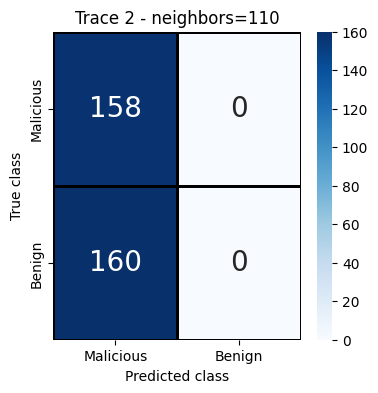

Trace {trace}: Highest acheived macro average F1 was 0.331924 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49686   1.00000   0.66387       158
           1    0.00000   0.00000   0.00000       160

    accuracy                        0.49686       318
   macro avg    0.24843   0.50000   0.33193       318
weighted avg    0.24687   0.49686   0.32985       318



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



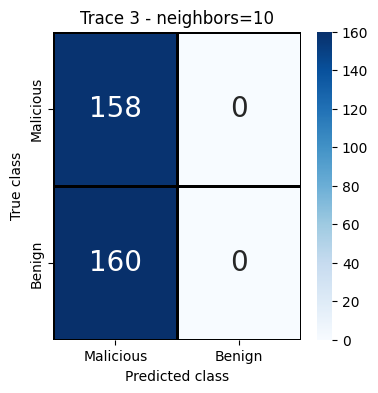

Trace {trace}: Highest acheived macro average F1 was 0.331404 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49686   1.00000   0.66387       158
           1    0.00000   0.00000   0.00000       160

    accuracy                        0.49686       318
   macro avg    0.24843   0.50000   0.33193       318
weighted avg    0.24687   0.49686   0.32985       318



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



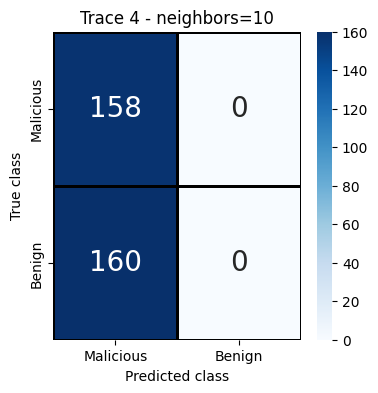

Trace {trace}: Highest acheived macro average F1 was 0.332584 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49686   1.00000   0.66387       158
           1    0.00000   0.00000   0.00000       160

    accuracy                        0.49686       318
   macro avg    0.24843   0.50000   0.33193       318
weighted avg    0.24687   0.49686   0.32985       318



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



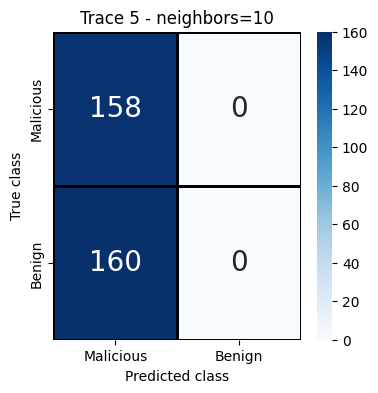

Trace {trace}: Highest acheived macro average F1 was 0.332767 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49686   1.00000   0.66387       158
           1    0.00000   0.00000   0.00000       160

    accuracy                        0.49686       318
   macro avg    0.24843   0.50000   0.33193       318
weighted avg    0.24687   0.49686   0.32985       318



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



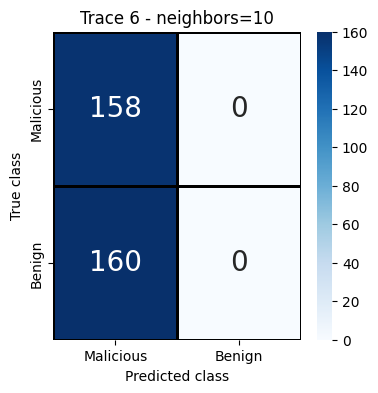

Trace {trace}: Highest acheived macro average F1 was 0.332209 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49686   1.00000   0.66387       158
           1    0.00000   0.00000   0.00000       160

    accuracy                        0.49686       318
   macro avg    0.24843   0.50000   0.33193       318
weighted avg    0.24687   0.49686   0.32985       318



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



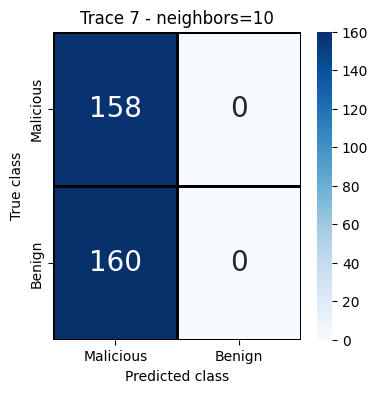

Trace {trace}: Highest acheived macro average F1 was 0.331933 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49686   1.00000   0.66387       158
           1    0.00000   0.00000   0.00000       160

    accuracy                        0.49686       318
   macro avg    0.24843   0.50000   0.33193       318
weighted avg    0.24687   0.49686   0.32985       318



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



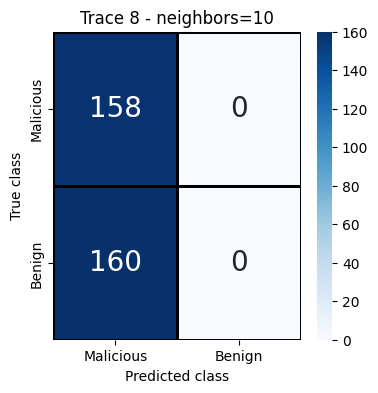

In [19]:
conf_matrix_list_lof = []

for trace in range(1, 9):

    spoofed_data = data_preprocessing('../data/drive-me-not/spoofed/spoofed_trace'+str(trace)+'.csv',
                                    selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                                    trace_num=trace)

    spoofed_for_test = process_spoofed_data(spoofed_data, scaler, pca_train)
    
    label_lof = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
    spoofed_for_test['label_lof'] = label_lof
    spoofed_for_test
    
    neighbor_opt, fscore = optimize_LocalOutlierFactor(
    df_train_lof, 
    spoofed_for_test, 
    neighbors_arange=(10,3000,100)
    )
    
    print("Trace {trace}: Highest acheived macro average F1 was %f using %f neighbours" % (fscore, neighbor_opt))
    print(metrics.classification_report(y_true, y_pred, digits=5))
    
    plot_cf_matrix(conf_matrix, 
                title=f'Trace {trace} - neighbors={neighbor_opt}',
                path=f'../outputs/img/lof/trace{trace}_cf_matrix_neighbor_{neighbor_opt}.png')

## Autoencoder

An Autoencoder Neural Network works by taking input, compressing it and trying to *reproduce the same input*. It is trained on a benign dataset using MSE. 

**Threshold**: If the MSE of the reconstructed output is over a delta threshold, 𝑇, it is classified as a novelty.
The paper did not tell us how to pick the proper threshold.

In [20]:
df_train_ae = df_train.drop(columns=['trace'])

### Autoencoder data preparation

In [84]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(df_train_ae, df_train_ae, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# turn to tensor
autoencoder_X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
autoencoder_y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
autoencoder_X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
autoencoder_y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
autoencoder_X_val_tensor = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
autoencoder_y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32)

# create TensorDataset
autoencoder_train_dataset = TensorDataset(autoencoder_X_train_tensor, autoencoder_y_train_tensor)
autoencoder_test_dataset = TensorDataset(autoencoder_X_test_tensor, autoencoder_y_test_tensor)
autoencoder_val_dataset = TensorDataset(autoencoder_X_val_tensor, autoencoder_y_val_tensor)

### Autoencoder Training

Monitor on wandb 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kennethwwwww. Use `wandb login --relogin` to force relogin


Epoch 1/100


100%|██████████| 72/72 [00:00<00:00, 1306.97it/s]


Train Loss: 4.440019078552723


100%|██████████| 16/16 [00:00<00:00, 3307.32it/s]


Epoch 2/100


100%|██████████| 72/72 [00:00<00:00, 1722.41it/s]


Train Loss: 1.1397005515173078


100%|██████████| 16/16 [00:00<00:00, 3263.41it/s]


Epoch 3/100


100%|██████████| 72/72 [00:00<00:00, 1649.94it/s]


Train Loss: 0.6976501038298011


100%|██████████| 16/16 [00:00<00:00, 3474.62it/s]


Epoch 4/100


100%|██████████| 72/72 [00:00<00:00, 1580.06it/s]


Train Loss: 0.6654108818620443


100%|██████████| 16/16 [00:00<00:00, 2854.12it/s]


Epoch 5/100


100%|██████████| 72/72 [00:00<00:00, 1394.59it/s]


Train Loss: 0.6143951350823045


100%|██████████| 16/16 [00:00<00:00, 3294.17it/s]


Epoch 6/100


100%|██████████| 72/72 [00:00<00:00, 737.60it/s]


Train Loss: 0.5235927226021886


100%|██████████| 16/16 [00:00<00:00, 3257.24it/s]


Epoch 7/100


100%|██████████| 72/72 [00:00<00:00, 1520.78it/s]


Train Loss: 0.39459855598397553


100%|██████████| 16/16 [00:00<00:00, 687.91it/s]


Epoch 8/100


100%|██████████| 72/72 [00:00<00:00, 1382.60it/s]


Train Loss: 0.30078944528941065


100%|██████████| 16/16 [00:00<00:00, 3611.69it/s]


Epoch 9/100


100%|██████████| 72/72 [00:00<00:00, 1604.21it/s]


Train Loss: 0.27412015351001173


100%|██████████| 16/16 [00:00<00:00, 3708.08it/s]


Epoch 10/100


100%|██████████| 72/72 [00:00<00:00, 1550.56it/s]


Train Loss: 0.2617535790777765


100%|██████████| 16/16 [00:00<00:00, 3305.69it/s]


Epoch 11/100


100%|██████████| 72/72 [00:00<00:00, 1565.56it/s]


Train Loss: 0.2554328328697011


100%|██████████| 16/16 [00:00<00:00, 3838.96it/s]


Epoch 12/100


100%|██████████| 72/72 [00:00<00:00, 742.38it/s]


Train Loss: 0.2432743827230297


100%|██████████| 16/16 [00:00<00:00, 3867.50it/s]


Epoch 13/100


100%|██████████| 72/72 [00:00<00:00, 1079.95it/s]


Train Loss: 0.2287082498660311


100%|██████████| 16/16 [00:00<00:00, 3258.50it/s]


Epoch 14/100


100%|██████████| 72/72 [00:00<00:00, 1248.91it/s]


Train Loss: 0.21160470705945045


100%|██████████| 16/16 [00:00<00:00, 2875.15it/s]


Epoch 15/100


100%|██████████| 72/72 [00:00<00:00, 1429.17it/s]


Train Loss: 0.19333777873544022


100%|██████████| 16/16 [00:00<00:00, 2952.57it/s]


Epoch 16/100


100%|██████████| 72/72 [00:00<00:00, 1445.96it/s]


Train Loss: 0.17211841559037566


100%|██████████| 16/16 [00:00<00:00, 3448.38it/s]


Epoch 17/100


100%|██████████| 72/72 [00:00<00:00, 1561.13it/s]


Train Loss: 0.14885625668102875


100%|██████████| 16/16 [00:00<00:00, 3330.46it/s]


Epoch 18/100


100%|██████████| 72/72 [00:00<00:00, 1615.18it/s]


Train Loss: 0.12193818419473246


100%|██████████| 16/16 [00:00<00:00, 3679.82it/s]


Epoch 19/100


100%|██████████| 72/72 [00:00<00:00, 737.93it/s]


Train Loss: 0.09535928544937633


100%|██████████| 16/16 [00:00<00:00, 3619.09it/s]


Epoch 20/100


100%|██████████| 72/72 [00:00<00:00, 1164.05it/s]


Train Loss: 0.07719101244583726


100%|██████████| 16/16 [00:00<00:00, 3998.86it/s]


Epoch 21/100


100%|██████████| 72/72 [00:00<00:00, 1625.07it/s]


Train Loss: 0.06474931261618622


100%|██████████| 16/16 [00:00<00:00, 3547.73it/s]


Epoch 22/100


100%|██████████| 72/72 [00:00<00:00, 1504.61it/s]


Train Loss: 0.05320214942912571


100%|██████████| 16/16 [00:00<00:00, 3523.51it/s]


Epoch 23/100


100%|██████████| 72/72 [00:00<00:00, 1526.53it/s]


Train Loss: 0.042045927242725156


100%|██████████| 16/16 [00:00<00:00, 3201.30it/s]


Epoch 24/100


100%|██████████| 72/72 [00:00<00:00, 1458.05it/s]


Train Loss: 0.03450211758899968


100%|██████████| 16/16 [00:00<00:00, 3442.36it/s]


Epoch 25/100


100%|██████████| 72/72 [00:00<00:00, 1595.92it/s]


Train Loss: 0.028275931254029274


100%|██████████| 16/16 [00:00<00:00, 3771.01it/s]


Epoch 26/100


100%|██████████| 72/72 [00:00<00:00, 731.57it/s]


Train Loss: 0.0246234758378705


100%|██████████| 16/16 [00:00<00:00, 3693.59it/s]


Epoch 27/100


100%|██████████| 72/72 [00:00<00:00, 1567.00it/s]


Train Loss: 0.022410425764974207


100%|██████████| 16/16 [00:00<00:00, 3584.88it/s]


Epoch 28/100


100%|██████████| 72/72 [00:00<00:00, 1560.31it/s]


Train Loss: 0.021142571204109117


100%|██████████| 16/16 [00:00<00:00, 3707.88it/s]


Epoch 29/100


100%|██████████| 72/72 [00:00<00:00, 1614.31it/s]


Train Loss: 0.020117649728490505


100%|██████████| 16/16 [00:00<00:00, 3718.15it/s]


Epoch 30/100


100%|██████████| 72/72 [00:00<00:00, 1584.43it/s]


Train Loss: 0.019511708422214724


100%|██████████| 16/16 [00:00<00:00, 3205.89it/s]


Epoch 31/100


100%|██████████| 72/72 [00:00<00:00, 1418.13it/s]


Train Loss: 0.019166197700542398


100%|██████████| 16/16 [00:00<00:00, 3250.14it/s]


Epoch 32/100


100%|██████████| 72/72 [00:00<00:00, 1355.31it/s]


Train Loss: 0.01879711890069302


100%|██████████| 16/16 [00:00<00:00, 3207.11it/s]


Epoch 33/100


100%|██████████| 72/72 [00:00<00:00, 602.04it/s]


Train Loss: 0.01792925564950565


100%|██████████| 16/16 [00:00<00:00, 3312.06it/s]


Epoch 34/100


100%|██████████| 72/72 [00:00<00:00, 1627.45it/s]


Train Loss: 0.018564084493846167


100%|██████████| 16/16 [00:00<00:00, 3700.11it/s]


Epoch 35/100


100%|██████████| 72/72 [00:00<00:00, 1690.82it/s]


Train Loss: 0.01783346682350384


100%|██████████| 16/16 [00:00<00:00, 3632.22it/s]


Epoch 36/100


100%|██████████| 72/72 [00:00<00:00, 1700.76it/s]


Train Loss: 0.01718857498053694


100%|██████████| 16/16 [00:00<00:00, 2522.32it/s]


Epoch 37/100


100%|██████████| 72/72 [00:00<00:00, 1180.66it/s]


Train Loss: 0.01680230788042536


100%|██████████| 16/16 [00:00<00:00, 3347.91it/s]


Epoch 38/100


100%|██████████| 72/72 [00:00<00:00, 1673.02it/s]


Train Loss: 0.016459970705909654


100%|██████████| 16/16 [00:00<00:00, 3478.95it/s]


Epoch 39/100


100%|██████████| 72/72 [00:00<00:00, 1733.43it/s]


Train Loss: 0.01631296104460489


100%|██████████| 16/16 [00:00<00:00, 3515.03it/s]


Epoch 40/100


100%|██████████| 72/72 [00:00<00:00, 1666.12it/s]


Train Loss: 0.016130204377986956


100%|██████████| 16/16 [00:00<00:00, 3481.83it/s]


Epoch 41/100


100%|██████████| 72/72 [00:00<00:00, 1679.42it/s]


Train Loss: 0.015917568365694024


100%|██████████| 16/16 [00:00<00:00, 3403.60it/s]


Epoch 42/100


100%|██████████| 72/72 [00:00<00:00, 1262.36it/s]


Train Loss: 0.015844868088606745


100%|██████████| 16/16 [00:00<00:00, 3374.00it/s]


Epoch 43/100


100%|██████████| 72/72 [00:00<00:00, 698.16it/s]


Train Loss: 0.015798885528056417


100%|██████████| 16/16 [00:00<00:00, 2017.40it/s]


Epoch 44/100


100%|██████████| 72/72 [00:00<00:00, 1310.38it/s]


Train Loss: 0.015733554391772486


100%|██████████| 16/16 [00:00<00:00, 3322.06it/s]


Epoch 45/100


100%|██████████| 72/72 [00:00<00:00, 1286.04it/s]


Train Loss: 0.015127801198104862


100%|██████████| 16/16 [00:00<00:00, 3405.68it/s]


Epoch 46/100


100%|██████████| 72/72 [00:00<00:00, 1347.71it/s]


Train Loss: 0.014877742694807239


100%|██████████| 16/16 [00:00<00:00, 3150.21it/s]


Epoch 47/100


100%|██████████| 72/72 [00:00<00:00, 1396.92it/s]


Train Loss: 0.015180620073806494


100%|██████████| 16/16 [00:00<00:00, 3826.05it/s]


Epoch 48/100


100%|██████████| 72/72 [00:00<00:00, 1419.03it/s]


Train Loss: 0.015097160263394471


100%|██████████| 16/16 [00:00<00:00, 3509.69it/s]


Epoch 49/100


100%|██████████| 72/72 [00:00<00:00, 674.69it/s]


Train Loss: 0.014733946205524262


100%|██████████| 16/16 [00:00<00:00, 3293.04it/s]


Epoch 50/100


100%|██████████| 72/72 [00:00<00:00, 1454.17it/s]


Train Loss: 0.014204663391865324


100%|██████████| 16/16 [00:00<00:00, 3572.28it/s]


Epoch 51/100


100%|██████████| 72/72 [00:00<00:00, 1530.51it/s]


Train Loss: 0.013970753425383009


100%|██████████| 16/16 [00:00<00:00, 3159.55it/s]


Epoch 52/100


100%|██████████| 72/72 [00:00<00:00, 1131.34it/s]


Train Loss: 0.01389098416257184


100%|██████████| 16/16 [00:00<00:00, 3677.20it/s]


Epoch 53/100


100%|██████████| 72/72 [00:00<00:00, 1489.73it/s]


Train Loss: 0.01359957954264246


100%|██████████| 16/16 [00:00<00:00, 3115.26it/s]


Epoch 54/100


100%|██████████| 72/72 [00:00<00:00, 1409.05it/s]


Train Loss: 0.013285903587529901


100%|██████████| 16/16 [00:00<00:00, 3022.24it/s]


Epoch 55/100


100%|██████████| 72/72 [00:00<00:00, 641.02it/s]


Train Loss: 0.013032281036430504


100%|██████████| 16/16 [00:00<00:00, 3005.32it/s]


Epoch 56/100


100%|██████████| 72/72 [00:00<00:00, 1452.14it/s]


Train Loss: 0.013129558254149742


100%|██████████| 16/16 [00:00<00:00, 3680.63it/s]


Epoch 57/100


100%|██████████| 72/72 [00:00<00:00, 1485.39it/s]


Train Loss: 0.012874261039542034


100%|██████████| 16/16 [00:00<00:00, 3650.99it/s]


Epoch 58/100


100%|██████████| 72/72 [00:00<00:00, 1564.06it/s]


Train Loss: 0.012068450843798928


100%|██████████| 16/16 [00:00<00:00, 3535.21it/s]


Epoch 59/100


100%|██████████| 72/72 [00:00<00:00, 1531.79it/s]


Train Loss: 0.01190465662511997


100%|██████████| 16/16 [00:00<00:00, 3479.13it/s]


Epoch 60/100


100%|██████████| 72/72 [00:00<00:00, 1655.07it/s]


Train Loss: 0.01184087892761454


100%|██████████| 16/16 [00:00<00:00, 3771.01it/s]


Epoch 61/100


100%|██████████| 72/72 [00:00<00:00, 699.20it/s]


Train Loss: 0.011238180879445281


100%|██████████| 16/16 [00:00<00:00, 3642.27it/s]


Epoch 62/100


100%|██████████| 72/72 [00:00<00:00, 1567.91it/s]


Train Loss: 0.01113341608288465


100%|██████████| 16/16 [00:00<00:00, 3423.92it/s]


Epoch 63/100


100%|██████████| 72/72 [00:00<00:00, 1475.38it/s]


Train Loss: 0.010748606808192562


100%|██████████| 16/16 [00:00<00:00, 3525.74it/s]


Epoch 64/100


100%|██████████| 72/72 [00:00<00:00, 1170.58it/s]


Train Loss: 0.01054573807050474


100%|██████████| 16/16 [00:00<00:00, 3038.94it/s]


Epoch 65/100


100%|██████████| 72/72 [00:00<00:00, 1264.40it/s]


Train Loss: 0.010158419350773329


100%|██████████| 16/16 [00:00<00:00, 3594.67it/s]


Epoch 66/100


100%|██████████| 72/72 [00:00<00:00, 1400.43it/s]


Train Loss: 0.010092234377225395


100%|██████████| 16/16 [00:00<00:00, 3214.33it/s]


Epoch 67/100


100%|██████████| 72/72 [00:00<00:00, 1519.21it/s]


Train Loss: 0.009772309000254609


100%|██████████| 16/16 [00:00<00:00, 3839.40it/s]


Epoch 68/100


100%|██████████| 72/72 [00:00<00:00, 655.11it/s]


Train Loss: 0.009468680415011477


100%|██████████| 16/16 [00:00<00:00, 3501.64it/s]


Epoch 69/100


100%|██████████| 72/72 [00:00<00:00, 1501.59it/s]


Train Loss: 0.009122348255914403


100%|██████████| 16/16 [00:00<00:00, 3428.47it/s]


Epoch 70/100


100%|██████████| 72/72 [00:00<00:00, 1511.05it/s]


Train Loss: 0.008864138108037878


100%|██████████| 16/16 [00:00<00:00, 3838.74it/s]


Epoch 71/100


100%|██████████| 72/72 [00:00<00:00, 1619.91it/s]


Train Loss: 0.008669733702845406


100%|██████████| 16/16 [00:00<00:00, 3448.38it/s]


Epoch 72/100


100%|██████████| 72/72 [00:00<00:00, 1505.66it/s]


Train Loss: 0.00864165005623363


100%|██████████| 16/16 [00:00<00:00, 3545.48it/s]


Epoch 73/100


100%|██████████| 72/72 [00:00<00:00, 1604.71it/s]


Train Loss: 0.008090586041362258


100%|██████████| 16/16 [00:00<00:00, 3386.26it/s]


Epoch 74/100


100%|██████████| 72/72 [00:00<00:00, 667.12it/s]


Train Loss: 0.007735272320132935


100%|██████████| 16/16 [00:00<00:00, 3548.29it/s]


Epoch 75/100


100%|██████████| 72/72 [00:00<00:00, 1401.95it/s]


Train Loss: 0.007566698983282549


100%|██████████| 16/16 [00:00<00:00, 3794.89it/s]


Epoch 76/100


100%|██████████| 72/72 [00:00<00:00, 1543.91it/s]


Train Loss: 0.007340692303841934


100%|██████████| 16/16 [00:00<00:00, 3606.06it/s]


Epoch 77/100


100%|██████████| 72/72 [00:00<00:00, 1186.90it/s]


Train Loss: 0.0071719630905136


100%|██████████| 16/16 [00:00<00:00, 2908.04it/s]


Epoch 78/100


100%|██████████| 72/72 [00:00<00:00, 1592.39it/s]


Train Loss: 0.006999123848800082


100%|██████████| 16/16 [00:00<00:00, 3759.39it/s]


Epoch 79/100


100%|██████████| 72/72 [00:00<00:00, 1519.00it/s]


Train Loss: 0.0067835173358616885


100%|██████████| 16/16 [00:00<00:00, 3388.48it/s]


Epoch 80/100


100%|██████████| 72/72 [00:00<00:00, 631.36it/s]


Train Loss: 0.006883163729071384


100%|██████████| 16/16 [00:00<00:00, 2814.38it/s]


Epoch 81/100


100%|██████████| 72/72 [00:00<00:00, 1337.72it/s]


Train Loss: 0.0064567228218948


100%|██████████| 16/16 [00:00<00:00, 3504.20it/s]


Epoch 82/100


100%|██████████| 72/72 [00:00<00:00, 1479.90it/s]


Train Loss: 0.006058092396415304


100%|██████████| 16/16 [00:00<00:00, 3610.14it/s]


Epoch 83/100


100%|██████████| 72/72 [00:00<00:00, 1461.28it/s]


Train Loss: 0.005954891981673427


100%|██████████| 16/16 [00:00<00:00, 3158.96it/s]


Epoch 84/100


100%|██████████| 72/72 [00:00<00:00, 1355.50it/s]


Train Loss: 0.005718747757782694


100%|██████████| 16/16 [00:00<00:00, 3574.75it/s]


Epoch 85/100


100%|██████████| 72/72 [00:00<00:00, 1463.44it/s]


Train Loss: 0.005527936820726609


100%|██████████| 16/16 [00:00<00:00, 3471.39it/s]


Epoch 86/100


100%|██████████| 72/72 [00:00<00:00, 631.50it/s]


Train Loss: 0.005390898295445368


100%|██████████| 16/16 [00:00<00:00, 3476.78it/s]


Epoch 87/100


100%|██████████| 72/72 [00:00<00:00, 1361.82it/s]


Train Loss: 0.005330952564690961


100%|██████████| 16/16 [00:00<00:00, 3186.71it/s]


Epoch 88/100


100%|██████████| 72/72 [00:00<00:00, 1380.51it/s]


Train Loss: 0.0051625459054776


100%|██████████| 16/16 [00:00<00:00, 3561.10it/s]


Epoch 89/100


100%|██████████| 72/72 [00:00<00:00, 1524.82it/s]


Train Loss: 0.004957681685482385


100%|██████████| 16/16 [00:00<00:00, 3446.78it/s]


Epoch 90/100


100%|██████████| 72/72 [00:00<00:00, 1408.12it/s]


Train Loss: 0.004878293562796898


100%|██████████| 16/16 [00:00<00:00, 2881.32it/s]


Epoch 91/100


100%|██████████| 72/72 [00:00<00:00, 591.89it/s]


Train Loss: 0.004684121466198121


100%|██████████| 16/16 [00:00<00:00, 3477.50it/s]


Epoch 92/100


100%|██████████| 72/72 [00:00<00:00, 1569.41it/s]


Train Loss: 0.004642600164515898


100%|██████████| 16/16 [00:00<00:00, 3429.70it/s]


Epoch 93/100


100%|██████████| 72/72 [00:00<00:00, 1446.33it/s]


Train Loss: 0.0047953171633707825


100%|██████████| 16/16 [00:00<00:00, 3410.87it/s]


Epoch 94/100


100%|██████████| 72/72 [00:00<00:00, 1456.45it/s]


Train Loss: 0.004643203768864623


100%|██████████| 16/16 [00:00<00:00, 3144.16it/s]


Epoch 95/100


100%|██████████| 72/72 [00:00<00:00, 1361.58it/s]


Train Loss: 0.004395761163323186


100%|██████████| 16/16 [00:00<00:00, 3305.20it/s]


Epoch 96/100


100%|██████████| 72/72 [00:00<00:00, 1520.65it/s]


Train Loss: 0.004208052008834784


100%|██████████| 16/16 [00:00<00:00, 3696.03it/s]


Epoch 97/100


100%|██████████| 72/72 [00:00<00:00, 667.43it/s]


Train Loss: 0.004256213143889909


100%|██████████| 16/16 [00:00<00:00, 3205.74it/s]


Epoch 98/100


100%|██████████| 72/72 [00:00<00:00, 1389.67it/s]


Train Loss: 0.0042637456172087695


100%|██████████| 16/16 [00:00<00:00, 3898.73it/s]


Epoch 99/100


100%|██████████| 72/72 [00:00<00:00, 1576.25it/s]


Train Loss: 0.004135927956667729


100%|██████████| 16/16 [00:00<00:00, 3173.30it/s]


Epoch 100/100


100%|██████████| 72/72 [00:00<00:00, 1382.01it/s]


Train Loss: 0.004203879265332944


100%|██████████| 16/16 [00:00<00:00, 3330.46it/s]


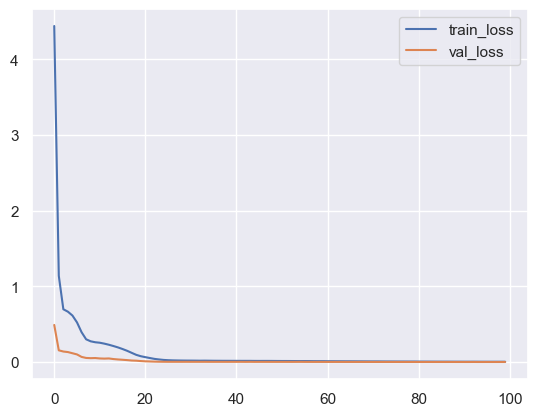

Finished Training


loss,█▃▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,8e-05
val_loss,0.00078


In [85]:
df_train, pca_train

from models.autoencoder import Autoencoder
from utils.trainer import Trainer
from sklearn.model_selection import train_test_split

FIRST_LAYER_SIZE = 25
HIDDEN_SIZE = 6
LAST_LAYER_SIZE = 25
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 100

# creare Dataloader
autoencoder_train_dataloader = DataLoader(autoencoder_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
autoencoder_test_dataloader = DataLoader(autoencoder_test_dataset, batch_size=BATCH_SIZE, shuffle=True)
autoencoder_val_dataloader = DataLoader(autoencoder_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

autoencoder_model = Autoencoder(input_size=N_COMPONENTS,
                                first_layer_size= FIRST_LAYER_SIZE,
                                hidden_size= HIDDEN_SIZE,
                                last_layer_size= LAST_LAYER_SIZE,
                                output_size= N_COMPONENTS,
                                )

autoencoder_criterion = torch.nn.MSELoss()
#adam optimizer
autoencoder_optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)

autoencoder_trainer = Trainer(model=autoencoder_model, 
                              train_loader=autoencoder_train_dataloader,
                              val_loader=autoencoder_val_dataloader,
                              criterion=autoencoder_criterion,
                              optimizer=autoencoder_optimizer,
                              if_wandb=True,
                              wandb_project_name="autoencoder",)

autoencoder_trainer.train(epochs=EPOCHS)

## raytune

### autoencoder model

In [23]:

# self-defined autoencoder model

import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error

N_COMPONENTS = 3

class Autoencoder(nn.Module):
    """
    Autoencoder class

    Parameters
    ----------
    nn : _type_
        _description_
    """
    
    def __init__(self, input_size=N_COMPONENTS, 
                 first_layer_size=25, 
                 hidden_size=3, 
                 last_layer_size=25, 
                 output_size=N_COMPONENTS,
                 **kwargs):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, first_layer_size),
            nn.ReLU(True),
            nn.Linear(first_layer_size, hidden_size),
            nn.ReLU(True)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, last_layer_size),
            nn.ReLU(True),
            nn.Linear(last_layer_size, output_size),
            nn.Sigmoid()
            )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
    
def predict_spoofed(y_pred, spoofed_ae, T) -> list:
    """ 
    Predict spoofed data using the autoencoder model, over a threshold T.
    """
    
    spoofed_pred = []
    
    for y_p, s_t in zip(y_pred, spoofed_ae):
        
        mse = mean_squared_error(y_p, s_t)
        if mse > T:
            # larger than threshold, spoofed
            spoofed_pred.append(-1)
        else:
            # smaller than threshold, benign
            spoofed_pred.append(1)
            
    return spoofed_pred

### define function

In [77]:
from models import autoencoder 
import tqdm
# import Checkpoint
from ray.train import Checkpoint

def ray_trainer(config, df_train_ae):
    
    model = Autoencoder(hidden_size=config['hidden_size'])
    
    
    from torch.utils.data import TensorDataset
    from sklearn.model_selection import train_test_split

    X_train, X_temp, y_train, y_temp = train_test_split(df_train_ae, df_train_ae, test_size=0.3, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # turn to tensor
    autoencoder_X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    autoencoder_y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    autoencoder_X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    autoencoder_y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
    autoencoder_X_val_tensor = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
    autoencoder_y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32)

    # create TensorDataset
    autoencoder_train_dataset = TensorDataset(autoencoder_X_train_tensor, autoencoder_y_train_tensor)
    autoencoder_test_dataset = TensorDataset(autoencoder_X_test_tensor, autoencoder_y_test_tensor)
    autoencoder_val_dataset = TensorDataset(autoencoder_X_val_tensor, autoencoder_y_val_tensor)
    
    train_loader = DataLoader(autoencoder_train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(autoencoder_test_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(autoencoder_val_dataset, batch_size=config['batch_size'], shuffle=True)


    criterion = torch.nn.MSELoss()
    #adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    

        
    def train_epoch():
        
        running_loss = 0.0
        
        # print progress bar using tqdm, only when epoch % 10 == 0
        
        for i, data in tqdm.tqdm(enumerate(train_loader), 
                                    total=len(train_loader),
                                    leave=True,
                                    ):
            
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # Convert to float
            inputs, labels = inputs.float(), labels.float()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            loss.backward()
            
            # Update model parameters
            optimizer.step()
            
            running_loss += loss.item()         


        print(f"Train Loss: {running_loss}")
    
        return running_loss
             
                
    def validate_epoch():
        """Execute validation process for one epoch."""
        # forward pass
        model.eval()
        
        val_loss = 0.0
        
        with torch.no_grad():
            for i, data in tqdm.tqdm(enumerate(val_loader), 
                                        total=len(val_loader),
                                        leave=True,
                                        ):
                inputs, labels = data
                inputs, labels = inputs.float(), labels.float()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()

            
        model.train()
        
        return val_loss
    
    
    train_loss = []
    val_loss = []
    
    epochs = 100
    
    for epoch in range(epochs):
        
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss.append(train_epoch())
        val_loss.append(validate_epoch())
    
    print("Finished Training")  
    
    return {"train_loss": train_loss[-1], "val_loss": val_loss[-1]}
    


### raytune train

In [78]:
from ray import tune
import ray
from functools import partial

import sys
sys.path.append('../')
# from utils.trainer import ray_trainer


trial_space = {
    # This is an example parameter. You could replace it with filesystem paths,
    # model types, or even full nested Python dicts of model configurations, etc.,
    # that enumerate the set of trials to run.
    "lr": tune.grid_search([0.001, 0.01, 0.1]),
    "batch_size": tune.grid_search([32, 64]),
    "hidden_size": tune.grid_search([3, 6]),
}

train_function = partial(ray_trainer, df_train_ae=df_train_ae)

train_model = tune.with_resources(train_function, {"cpu": 1})

from ray.train import RunConfig

tuner = tune.Tuner(train_function, param_space=trial_space, 
                   )
result_grid = tuner.fit()

2024-06-18 01:05:12,174	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/keniwo/ray_results/ray_trainer_2024-06-18_01-04-55' in 0.0083s.
2024-06-18 01:05:12,177	INFO tune.py:1041 -- Total run time: 16.21 seconds (16.19 seconds for the tuning loop).


In [79]:
best_result = result_grid.get_best_result(metric="val_loss", mode="min", scope="last")
best_checkpoint = best_result.checkpoint 
df_results = result_grid.get_dataframe() 

In [81]:
best_result.config


{'lr': 0.001, 'batch_size': 32, 'hidden_size': 6}

### Tests

In [87]:
#save model
autoencoder_trainer.save_model(path = f'../saved_models/pca_autoencoder/autoencoder_{HIDDEN_SIZE}_{LEARNING_RATE}_{BATCH_SIZE}.pth')

In [88]:
# test model on autoencoder_test_dataloader

autoencoder_trainer.model.eval()

losses = []

for i, (x, y) in enumerate(autoencoder_test_dataloader):
    y_pred = autoencoder_trainer.model(x)
    loss = autoencoder_trainer.criterion(y_pred, y)
    losses.append(loss.item())
    
print(f"Average loss on test set: {np.mean(losses)}")

Average loss on test set: 5.2383298225322505e-05


### Use Autoencoder to detect spoofing by a Threshold $T$

In [96]:
# spoofing threshold

def max_element_index(lst):
    if not lst:  # Check if the list is empty
        return None, None

    max_value = lst[0]  # Initialize max_value with the first element
    max_index = 0  # Initialize max_index with the index of the first element

    for i, value in enumerate(lst):
        if value > max_value:
            max_value = value
            max_index = i

    return max_value, max_index

Search for a ideal T

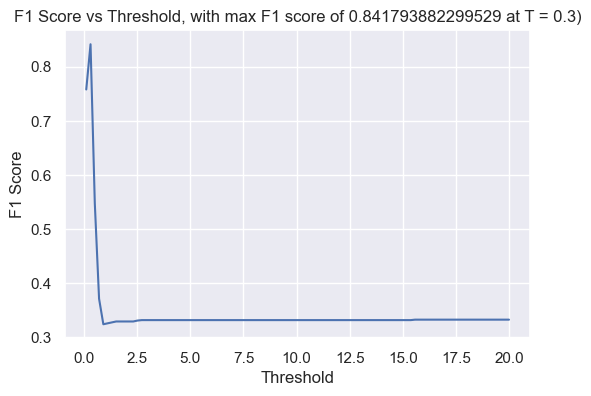

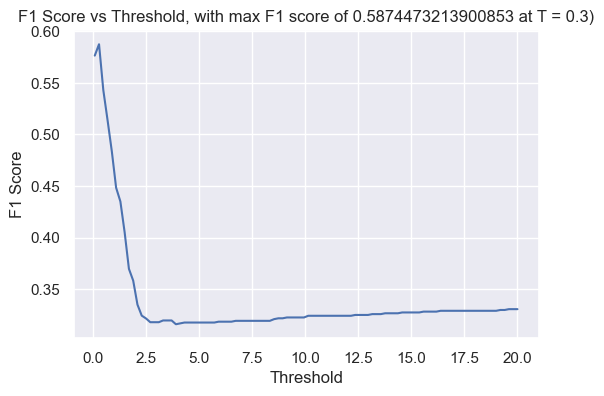

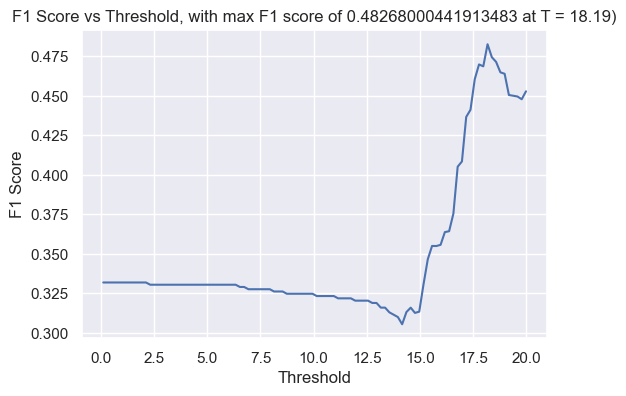

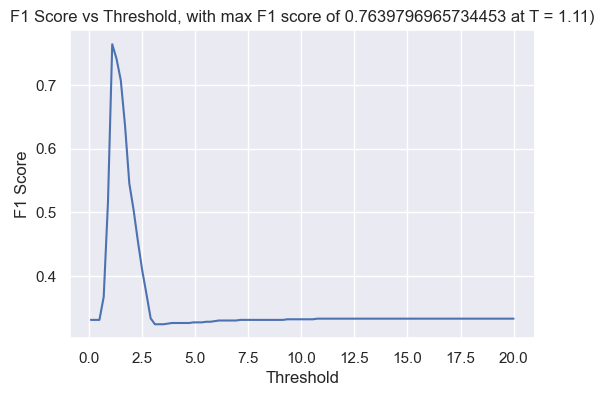

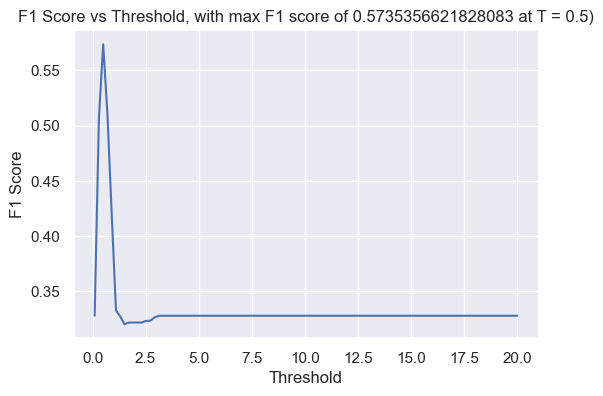

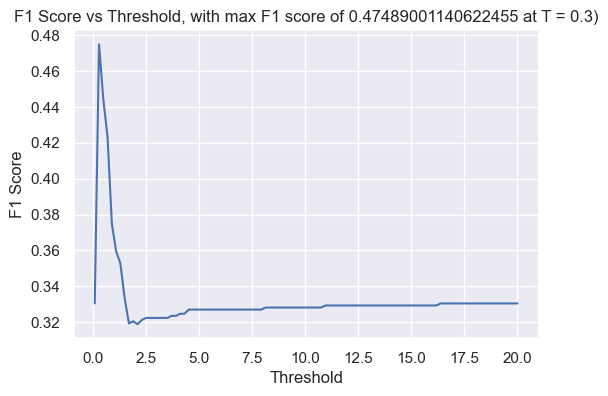

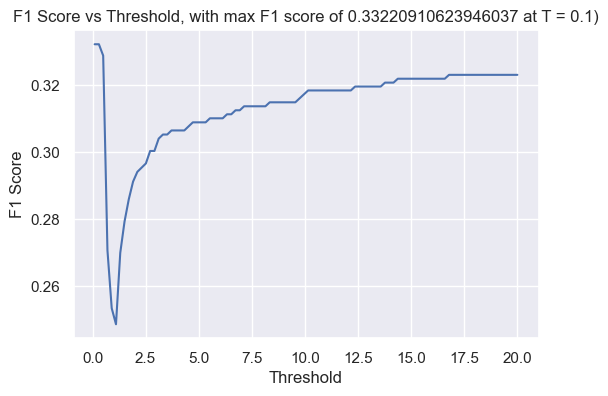

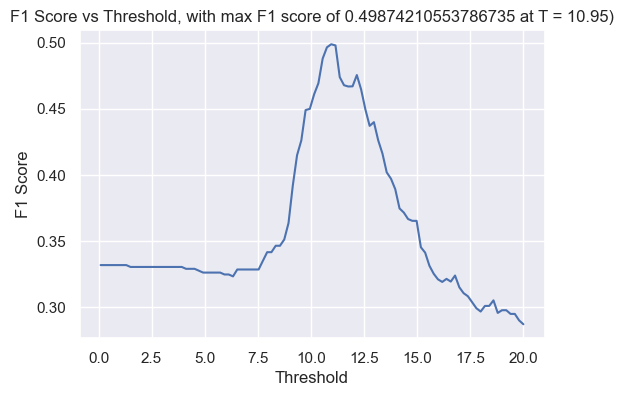

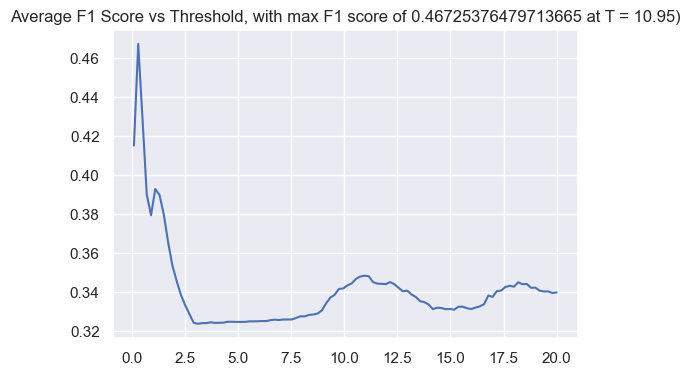

In [99]:
from sklearn.metrics import mean_squared_error
from models.autoencoder import predict_spoofed
from sklearn import metrics
from matplotlib import pyplot as plt

f1_all_traces = []

for trace in range(1, 9):
    
    spoofed_data = data_preprocessing('../data/drive-me-not/spoofed/spoofed_trace'+str(trace)+'.csv',
                                    selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                                    trace_num=trace)

    spoofed_for_test = process_spoofed_data(spoofed_data, scaler, pca_train)

    label_ae = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
    spoofed_for_test['label_ocsvm'] = label_ae
    
    spoofed_ae = spoofed_for_test[['pca-one', 'pca-two', 'pca-three']].values
    
    autoencoder_trainer.model.eval()
    
    y_pred = autoencoder_trainer.model(torch.tensor(spoofed_ae, dtype=torch.float32)).detach().numpy()

    f1_list = []
    cf_matrix_list = []
    T_range = np.linspace(0.1, 20, 100)
    max_f1 = 0

    for T in T_range:
        spoofed_pred = predict_spoofed(y_pred, spoofed_ae, T)
        y_true = spoofed_for_test.label_ocsvm
        
        metrics.confusion_matrix(y_true, spoofed_pred)
        cf_matrix_list.append(
            metrics.confusion_matrix(y_true, spoofed_pred)
            )
        
        _, _, f1_score_ae, _ = score(y_true, spoofed_pred, average='macro', zero_division=1)
        
        
        f1_list.append(f1_score_ae)

    f1_all_traces.append(f1_list)
    max_f1, max_f1_index = max_element_index(f1_list)
    
    sns.set_theme(context='notebook', style='darkgrid')
    
    fig = plt.figure(figsize=(6, 4))
    plt.plot(T_range, f1_list)

    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score vs Threshold, with max F1 score of {max_f1} at T = { round(T_range[max_f1_index], 2) })')
    plt.savefig(f'../outputs/img/ae_threshold/trace{trace}_f1.png')
    
# average f1 score on all traces

f1_avg_list = []

for i in range(len(T_range)):
    f1_sum = 0
    for f1_list in f1_all_traces:
        f1_sum += f1_list[i]
    f1_avg = f1_sum / len(f1_all_traces)
    f1_avg_list.append(f1_avg)
    
fig = plt.figure(figsize=(6, 4))
plt.plot(T_range, f1_avg_list)

max_f1, max_f1_index = max_element_index(f1_avg_list)
plt.title(f'Average F1 Score vs Threshold, with max F1 score of {max_f1} at T = {round(T_range[np.argmax(f1_list)], 2) })')
plt.savefig(f'../outputs/img/ae_threshold/avg_trace_f1.png')
    
